# outline

## LQG optimal controrl

In [190]:
# imports

import numpy as np
from plot_ult import * 

%matplotlib inline
np.set_printoptions(precision=3,suppress=True)

In [191]:
# LQG

max_linear_velocity = 2.0 # meters per second
max_angular_velocity = 1.5708 # radians per second


def state_space_model(A, state_t_minus_1, B, control_input_t_minus_1):
    '''
    1d world model.
    the task is to use contorl to move state to 0
    the dynamic is linear, defined in A.
    the control is clipped.

    input:
    A, linear state trainsition
    B, linear control matrix

    '''
    # make sure control with in range
    control_input_t_minus_1[0] = np.clip(control_input_t_minus_1[0],
                                                                            -max_linear_velocity,
                                                                            max_linear_velocity)
    # control_input_t_minus_1[1] = np.clip(control_input_t_minus_1[1], -max_angular_velocity,max_angular_velocity)
    
    # prediction
    state_estimate_t = (A @ state_t_minus_1) + (B @ control_input_t_minus_1) 
             
    return state_estimate_t


def lqr(actual_state_x, desired_state_xf, Q, R, A, B):
    """
    Discrete-time linear quadratic regulator for a nonlinear system.
 
    Compute the optimal control inputs given a nonlinear system, cost matrices, 
    current state, and a final state.
     
    Compute the control variables that minimize the cumulative cost.
 
    Solve for P using the dynamic programming method.
 
    :param actual_state_x: The current state of the system 
        3x1 NumPy Array given the state is [x,y,yaw angle] --->
        [meters, meters, radians]
    :param desired_state_xf: The desired state of the system
        3x1 NumPy Array given the state is [x,y,yaw angle] --->
        [meters, meters, radians]   
    Q: The state cost matrix
        3x3 NumPy Array
    R: The input cost matrix
        2x2 NumPy Array
    :param dt: The size of the timestep in seconds -> float
 
    :return: u_star: Optimal action u for the current state 
        2x1 NumPy Array given the control input vector is
        [linear velocity of the car, angular velocity of the car]
        [meters per second, radians per second]
    """
    # We want the system to stabilize at desired_state_xf.
    x_error = actual_state_x - desired_state_xf
    N = 50
    P = [None] * (N + 1)
    Qf = Q
    # LQR via Dynamic Programming
    P[N] = Qf
    # For i = N, ..., 1
    for i in range(N, 0, -1):
        # Discrete-time Algebraic Riccati equation to calculate the optimal 
        # state cost matrix
        P[i-1] = Q + A.T @ P[i] @ A - (A.T @ P[i] @ B) @ np.linalg.pinv(
            R + B.T @ P[i] @ B) @ (B.T @ P[i] @ A)      
    # Create a list of N elements
    K = [None] * N
    u = [None] * N
    # For i = 0, ..., N - 1
    for i in range(N):
        # Calculate the optimal feedback gain K
        K[i] = -np.linalg.pinv(R + B.T @ P[i+1] @ B) @ B.T @ P[i+1] @ A
        u[i] = K[i] @ x_error
    u_star = u[N-2]
    return u_star
 

def lqr(x, xf, Q, R, A, B, N=50):
    x_error = x - xf
    P = [None] * (N + 1)
    Qf = Q
    P[N] = Qf
    K = [None] * N # control gain
    u = [None] * N # control

    for i in range(N, 0, -1):
        P[i-1] = Q + A.T @ P[i] @ A - (A.T @ P[i] @ B) @ np.linalg.pinv(
            R + B.T @ P[i] @ B) @ (B.T @ P[i] @ A)   
           
    for i in range(N):
        K[i] = -np.linalg.pinv(R + B.T @ P[i+1] @ B) @ B.T @ P[i+1] @ A
        u[i] = K[i] @ x_error

    u_star = u[N-2]
    return u_star
 
 
def kf(x,P, y, u, A, B, H, Q_kf, R_kf,):
    
    x_hat=A@x + B@u
    P_hat=A@P@A.T + Q_kf

    err = y - H@x_hat
    S = H@P_hat@H.T + R_kf
    # print(P_hat, H, S)
    Kf = P_hat@H.T@np.linalg.pinv(S)

    x=x_hat +Kf@err
    P=P_hat - Kf@H@P_hat

    return x, P




Goal Has Been Reached Successfully!
Current State = [[ 0.091]
 [-0.013]]


Text(0.5, 0, 'time')

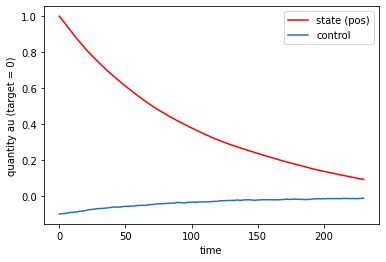

In [192]:
# const
dt = 0.1
tau = 0.5
tau_a=np.exp(-dt/tau)
actual_state_x = np.array([[1.],[0]]) 
desired_state_xf = np.array([[0.],[0.]])  
estimated_state_x=actual_state_x


A=np.array([[1.,dt],[0.,1-tau_a]])
B=np.array([[0.],[tau_a]])

R=np.ones((1,1))*0.8
Q = np.array([[1, 0],
            [0, .01]])

Q_kf=np.array([[0, 0],
            [0, .1]])
R_kf=np.array([[0.1]])
H=np.array([[0,1]])
P=np.diag([0.001,0.001])


# run the task
xs, x_hats=[],[]
us=[]
# Launch the robot, and have it move to the desired goal destination
for i in range(333):
    if i%10==0:
        # print(f'iteration = {i/10} seconds')
        # print(f'Current State = {actual_state_x}, Desired State = {desired_state_xf}')

        state_error = actual_state_x - desired_state_xf
        state_error_magnitude = np.linalg.norm(state_error)     
        # print(f'State Error Magnitude = {state_error_magnitude}')
        
    # LQR returns the optimal control input
    optimal_control_input = lqr(estimated_state_x, 
                                desired_state_xf, 
                                Q, R, A, B) 
        
    # print(f'Control Input = {optimal_control_input}')
                                    
    # We apply the optimal control to the robot
    # so we can get a new actual (estimated) state.
    actual_state_x = state_space_model(A, actual_state_x, B, 
                                    optimal_control_input)  
    
    y=H@actual_state_x+np.random.normal(0, R_kf) # the observation
    estimated_state_x,P = kf(estimated_state_x,P,y,optimal_control_input, A, B, H, Q_kf, R_kf)
    xs.append(actual_state_x);x_hats.append(estimated_state_x)
    us.append(optimal_control_input)
    # print(estimated_state_x,actual_state_x,P)
    # Stop as soon as we reach the goal
    # Feel free to change this threshold value.
    if state_error_magnitude < 0.1:
        print("\nGoal Has Been Reached Successfully!")
        print(f'Current State = {actual_state_x}')
        break


%matplotlib inline
plt.plot([x[0,0] for x in xs], 'r', label='state (pos)')
plt.plot(np.array(us).reshape(-1), label='control')
plt.legend()
plt.ylabel('quantity au (target = 0)')
plt.xlabel('time')


## RL

In [212]:


class Task():

    def __init__(self,A, B, H, R, init,target, timeout=333) -> None:
        '''
        A, state trainsition
        B, control
        
        H, observation (can be partial. shoudl be a bineary matrix)
        
        Q, state cost
        R, control cost
        '''
        self.A=A
        self.B=B
        self.R=R
        self.H=H
        self.init=init # init state
        self.target=target # target state
        self.timeout=timeout

    def reset(self,):
        self.s=self.init
        # logging
        self.t=0
        self.xs=[] 
        self.us=[]
        self.rs=[]
        return H@self.s
    
    def is_done(self,):
        state_error = self.s - self.target
        state_error_magnitude = np.linalg.norm(state_error) 
        rewarded=state_error_magnitude<0.1
        timeout=self.t>self.timeout

        return rewarded | timeout

    def compute_reward(self,a, scale=100):
        '''
        compute reward. use the same action cost as LQG, but use binary real reward
        '''
        state_error = self.s - self.target
        state_error_magnitude = np.linalg.norm(state_error) 
        state_reward=int(state_error_magnitude<0.1)*scale

        action_cost=a@self.R@a.T

        return state_reward-action_cost

    def step(self,a):
        next_s = state_space_model(self.A, self.s, self.B, 
                                    a) 
        self.s=next_s

        reward=self.compute_reward(a)
        done = self.is_done()
        
        
        self.xs.append(self.s)
        self.us.append(a)
        self.rs.append(reward)

        self.t+=1
        return self.H@self.s, reward, done


# actual_state_x = np.array([[1.],[0]]) 
# desired_state_xf = np.array([[0.],[0.]])  
# env=Task(A, B, H, R, actual_state_x,desired_state_xf)
# obs=env.reset()

# done=False
# while not done:
#     action = np.ones((1,1))*-1
#     # print(action)
#     obs, reward, done = env.step(np.array(action)) #track true next_x of monkey
    
    
# plt.plot([s[0,0] for s in env.xs[:555]])
# plt.plot([s[0,0] for s in env.us[:555]])

In [300]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam # use Adam optimizer for deep neural net
from torch.autograd import Variable
import copy
import random
from collections import deque, namedtuple


def init_weights(m, mean=0, std=0.1, bias=0):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean, std)
        nn.init.constant_(m.bias, bias)
    if isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, bias)
            elif 'weight' in name:
                nn.init.xavier_uniform_(param)
            else:
                raise ValueError()

def soft_update(target, source, tau):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)

def hard_update(target, source):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(param.data)

def variable(x, **kwargs):
    if torch.cuda.is_available():
        return Variable(x, **kwargs).cuda()
    return Variable(x, **kwargs)

Transition = namedtuple(
    'Transition', ('state', 'action', 'done', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity, priority=False):
        self.capacity = capacity
        self.priority = priority
        if priority:
            self.memory = PER(capacity=capacity)
        else:
            self.memory = deque(maxlen=capacity)

    def push(self, *args, err=None):
        """Saves a transition."""
        if self.priority:
            assert err is not None, "Need to pass float error to add to priority memory"
            self.memory.add(err, Transition(*args))
        else:
            self.memory.append(Transition(*args))

    def sample(self, batch_size):
        if self.priority:
            batch, idx, is_weights = self.memory.sample(batch_size)
        else:
            batch = random.sample(self.memory, batch_size)
            idx = None
        batch = Transition(*zip(*batch))
        return batch, idx

    def update(self, idx, err):
        assert self.priority, "Cannot call this function if not priority memory"
        self.memory.update(idx, err)

    def batch_update(self, ids, errs):
        for idx, err in zip(ids, errs):
            self.update(idx, err)
        return

    def __len__(self):
        return len(self.memory)
    
class Agent():

    def __init__(self, input_dim, action_dim, arg, filename=None, hidden_dim=128, gamma=0.99, tau=0.001, memory_size=1e6, device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")):

        self.device = device
        self.input_dim = input_dim
        self.action_dim = action_dim
        self.hidden_dim = hidden_dim
        self.gamma = gamma
        self.tau = tau
        self.data_path = arg.data_path

        print("Running Agent: using ", self.device)

        self.actor = Actor(input_dim, action_dim).to(self.device)
        self.target_actor = Actor(input_dim, action_dim).to(self.device)  # target NW
        self.critic = Critic(input_dim, action_dim, hidden_dim).to(self.device)
        self.target_critic = Critic(input_dim, action_dim, hidden_dim).to(self.device)# target NW

        self.actor_optim = Adam(self.actor.parameters(), lr=1e-4)
        self.critic_optim = Adam(self.critic.parameters(), lr=1e-3)

        self.priority = False
        self.memory = ReplayMemory(int(memory_size), priority=self.priority)

        self.args = (input_dim, action_dim, hidden_dim)
        hard_update(self.target_actor, self.actor)  # Make sure target is with the same weight
        hard_update(self.target_critic, self.critic)
        # self.create_save_file(filename)


    def select_action(self,  state, action_noise=None, param = None):

        state = Variable(state).to(self.device)
        
        if param is not None:
            mu = self.actor_perturbed(state).detach()
        else: # no parameter space noise
            mu = self.actor(state).detach()

        if action_noise is not None:
            mu += torch.Tensor(action_noise.noise()).to(self.device)
        return mu.clamp(-1, 1)

    def update_parameters(self, batch):
        states = variable(torch.cat(batch.state))
        next_states = variable(torch.cat(batch.next_state))
        actions = variable(torch.cat(batch.action))
        rewards = variable(torch.cat(batch.reward).unsqueeze(1))
        #masks = variable(torch.cat(batch.mask))
        dones = variable(torch.cat(batch.done))

        with torch.no_grad():
            next_actions = self.target_actor(next_states) # use target
            next_qvalues = self.target_critic(next_states, next_actions) # use target network
            #next_qvalues = self.target_critic(next_states, next_actions) * (1 - dones)
            target_qvalues = rewards + self.gamma * next_qvalues

        self.critic_optim.zero_grad()
        pred_qvalues = self.critic(states, actions)
        value_loss = torch.mean((pred_qvalues - target_qvalues)**2)
        value_loss.backward()
        self.critic_optim.step()

        self.actor_optim.zero_grad()
        policy_loss = -self.critic(states, self.actor(states))
        policy_loss = policy_loss.mean()
        policy_loss.backward()
        self.actor_optim.step()
        return policy_loss, value_loss

    def learn(self, epochs=2, batch_size=64):
        for epoch in range(epochs):
            # sample new batch here
            batch, _ = self.memory.sample(batch_size)
            losses = self.update_parameters(batch)
            soft_update(self.target_actor, self.actor, self.tau)
            soft_update(self.target_critic, self.critic, self.tau)

        return losses

    def save(self, filename, episode):
        state = {
            'args': self.args,
            'actor_dict': self.actor.state_dict(),
            'critic_dict': self.critic.state_dict(),
        }


        torch.save(state, self.file)
        if episode % 100 == 0:
            print("Saved to " + self.file)

    def load(self, filename):
        file = self.data_path +'trained_agent/'+filename+'.pth.tar'
        state = torch.load(file, map_location=lambda storage, loc: storage)
        if self.args != state['args']:
            print('Agent parameters from file are different from call')
            print('Overwriting agent to load file ... ')
            args = state['args']
            #self = Agent(*args)
            self.__init__(*args)

        self.actor.load_state_dict(state['actor_dict'])
        self.critic.load_state_dict(state['critic_dict'])
        hard_update(self.target_actor, self.actor)  # Make sure target is with the same weight
        hard_update(self.target_critic, self.critic)
        #print('Loaded')
        return

    def create_save_file(self, filename):
        path = self.data_path+'trained_agent'
        os.makedirs(path, exist_ok=True)
        if filename == None:
            self.file = next_path(path + '/' + 'ddpgmodel_%s.pth.tar')
        else: self.file = path + '/' + filename + '.pth.tar'

    def perturb_actor_parameters(self, param_noise):
        """Apply parameter noise to actor model, for exploration"""
        hard_update(self.actor_perturbed, self.actor)
        params = self.actor_perturbed.state_dict()
        for name in params:
            if 'ln' in name:
                pass
            param = params[name]
            if 'bn' not in name:
                random = torch.randn(param.shape).to(self.device)
                
                param += random * param_noise.current_stddev







class Actor(nn.Module):
    def __init__(self, OBS_DIM, ACTION_DIM, TARGET_DIM, RNN_SIZE, BN_SIZE, FC_SIZE, RNN):
        super().__init__()
        self.OBS_DIM = OBS_DIM
        self.ACTION_DIM = ACTION_DIM
        
        self.rnn1 = RNN(input_size=OBS_DIM + ACTION_DIM, hidden_size=RNN_SIZE)
        self.l1 = nn.Linear(RNN_SIZE, BN_SIZE)
        self.l2 = nn.Linear(BN_SIZE + TARGET_DIM, FC_SIZE)
        self.l3 = nn.Linear(FC_SIZE, FC_SIZE)
        self.l4 = nn.Linear(FC_SIZE, ACTION_DIM)
        
        self.apply(init_weights)

    def forward(self, x, hidden_in, return_hidden=True): 
        x_v = x[:, :, :self.OBS_DIM + self.ACTION_DIM]
        x_tar = x[:, :, self.OBS_DIM + self.ACTION_DIM:]
        
        if hidden_in is None:
            x_v, hidden_out = self.rnn1(x_v)
        else:
            x_v, hidden_out = self.rnn1(x_v, hidden_in)
          
        x_v = self.l1(x_v)
        x = F.relu(self.l2(torch.cat([x_v, x_tar], dim=2)))
        x = F.relu(self.l3(x))
        x = torch.tanh(self.l4(x))
        if return_hidden:
            return x, hidden_out
        else:
            return x

class Critic(nn.Module):
    def __init__(self, OBS_DIM, ACTION_DIM, TARGET_DIM, RNN_SIZE, BN_SIZE, FC_SIZE, RNN):
        super().__init__()
        self.OBS_DIM = OBS_DIM
        self.ACTION_DIM = ACTION_DIM
        
        # Q1 architecture
        self.rnn1 = RNN(input_size=OBS_DIM + ACTION_DIM, hidden_size=RNN_SIZE)
        self.l1 = nn.Linear(RNN_SIZE, BN_SIZE)
        self.l2 = nn.Linear(BN_SIZE + TARGET_DIM + ACTION_DIM, FC_SIZE)
        self.l3 = nn.Linear(FC_SIZE, FC_SIZE)  
        self.l4 = nn.Linear(FC_SIZE, 1)
        
        # Q2 architecture
        self.rnn2 = RNN(input_size=OBS_DIM + ACTION_DIM, hidden_size=RNN_SIZE)
        self.l5 = nn.Linear(RNN_SIZE, BN_SIZE)
        self.l6 = nn.Linear(BN_SIZE + TARGET_DIM + ACTION_DIM, FC_SIZE)
        self.l7 = nn.Linear(FC_SIZE, FC_SIZE)
        self.l8 = nn.Linear(FC_SIZE, 1)
        
        self.apply(init_weights)

    def forward(self, x, u, hidden_in1=None, hidden_in2=None, return_hidden=False):
        x_v = x[:, :, :self.OBS_DIM + self.ACTION_DIM]
        x_tar = x[:, :, self.OBS_DIM + self.ACTION_DIM:]
        
        if hidden_in1 is None:
            x_v1, hidden_out1 = self.rnn1(x_v)
        else:
            x_v1, hidden_out1 = self.rnn1(x_v, hidden_in1)
        x_v1 = self.l1(x_v1)
        x1 = F.relu(self.l2(torch.cat([x_v1, x_tar, u], dim=2)))
        x1 = F.relu(self.l3(x1))
        x1 = self.l4(x1)
        
        if hidden_in2 is None:
            x_v2, hidden_out2 = self.rnn2(x_v)
        else:
            x_v2, hidden_out2 = self.rnn2(x_v, hidden_in2)
        x_v2 = self.l5(x_v2)
        x2 = F.relu(self.l6(torch.cat([x_v2, x_tar, u], dim=2)))
        x2 = F.relu(self.l7(x2))
        x2 = self.l8(x2)
        
        if return_hidden:
            return x1, x2, hidden_in1, hidden_out2
        else:
            return x1, x2
    
    def Q1(self, x, u):
        x_v = x[:, :, :self.OBS_DIM + self.ACTION_DIM]
        x_tar = x[:, :, self.OBS_DIM + self.ACTION_DIM:]
        
        x_v1, _ = self.rnn1(x_v)
        x_v1 = self.l1(x_v1)
        x1 = F.relu(self.l2(torch.cat([x_v1, x_tar, u], dim=2)))
        x1 = F.relu(self.l3(x1))
        x1 = self.l4(x1)
        
        return x1

transition = namedtuple('transition', ('state', 'action', 'reward'))
class ReplayMemory():
    def __init__(self, MEMORY_SIZE, BATCH_SIZE):
        self.MEMORY_SIZE = MEMORY_SIZE
        self.SMALL_MEMORY_SIZE = int(MEMORY_SIZE / 10)
        self.BATCH_SIZE = BATCH_SIZE
        self.memory = []
        self.position = 0

    def push(self, *args):
        # a ring buffer
        if len(self.memory) < self.MEMORY_SIZE:
            self.memory.append(None)
            
        self.memory[self.position] = transition(*args)
        self.position = (self.position+1) % self.MEMORY_SIZE
        
    def sample(self):
        # 1. Sample a small memory.
        if len(self.memory) < self.SMALL_MEMORY_SIZE:
            small_memory = self.memory
        else:
            small_memory = random.sample(self.memory, self.SMALL_MEMORY_SIZE)
            
        # 2. Sample a trial length.
        traj_len = [traj.reward.shape[0] for traj in small_memory]
        traj_len = random.sample(traj_len, 1)[0]
        
        # 3. Get trials with same length.
        small_memory = [traj for traj in small_memory if traj.reward.shape[0] == traj_len]
        
        # 4. Sample a mini batch.
        batch = random.sample(small_memory, min(self.BATCH_SIZE, len(small_memory)))
        batch = transition(*zip(*batch))
        
        return batch
        
    def load(self, memory):          
        self.memory, self.position = memory
        
    def reset(self):
        self.memory = []
        self.position = 0

class BeliefStep(nn.Module):
    def __init__(self, arg):
        super().__init__()
        self.STATE_DIM = arg.STATE_DIM
        self.OBS_DIM = arg.OBS_DIM
        self.obs_noise_range = arg.obs_noise_range
        
        self.H = torch.zeros(self.OBS_DIM, self.STATE_DIM)
        self.H[0, 1] = 1
        
    @property
    def obs_noise_range(self):
        return self._obs_noise_range
    
    @obs_noise_range.setter
    def obs_noise_range(self, value):
        self._obs_noise_range = [0, 0] if value is None else value

    def reset(self, pro_gains, obs_noise_std=None):
        self.obs_noise_std = obs_noise_std
        
        if self.obs_noise_std is None:
            self.obs_noise_std = torch.zeros(1).uniform_(
                                    self.obs_noise_range[0], 
                                    self.obs_noise_range[1]) * pro_gains

    def forward(self, x):
        zita = (self.obs_noise_std * torch.randn(self.OBS_DIM)).view([-1, 1])
        o_t = self.H @ x + zita
        
        return o_t

class Arg:
    def __init__(self) -> None:
        self.data_path=None
        self.OBS_DIM=1
        self.ACTION_DIM=1
        self.TARGET_DIM=1
        self.RNN_SIZE=2
        self.BN_SIZE=1
        self.FC_SIZE=1
        self.RNN=nn.LSTM
        self.device='cpu'
        self.optimzer=Adam
        self.lr=0.001
        self.eps=1e-8
        self.MEMORY_SIZE = int(1e5)
        self.BATCH_SIZE = 16
        self.STATE_DIM = 2
        self.ACTION_DIM = 1
        self.OBS_DIM = 1
        self.TARGET_DIM = 2
        self.obs_noise_range = [0, 0.1]

arg=Arg()

class ActionNoise():
    def __init__(self, ACTION_DIM, mean, std=0.1):
        self.mu = torch.ones(ACTION_DIM) * mean
        self.std = std
        self.ACTION_DIM = ACTION_DIM

    def reset(self, mean, std):
        self.mu = torch.ones(self.ACTION_DIM) * mean
        self.std = std

    def noise(self):
        n = torch.randn(self.ACTION_DIM)
        return self.mu + self.std * n
    
std = 0.1 # this is for action space noise for exploration
noise = ActionNoise(1, mean=0., std=std)

class Agent():
    def __init__(self, arg):
        self.__dict__ .update(arg.__dict__)
        # self.data_path = self.data_path_

        self.actor = Actor(self.OBS_DIM, self.ACTION_DIM, self.TARGET_DIM, 
                           self.RNN_SIZE, self.BN_SIZE, self.FC_SIZE, self.RNN).to(self.device)
        self.target_actor = copy.deepcopy(self.actor).to(self.device)
        self.target_actor.eval()
        self.actor_optim = self.optimzer(self.actor.parameters(), lr=self.lr, eps=self.eps)
        
        self.critic = Critic(self.OBS_DIM, self.ACTION_DIM, self.TARGET_DIM, 
                           self.RNN_SIZE, self.BN_SIZE, self.FC_SIZE, self.RNN).to(self.device)
        self.target_critic = copy.deepcopy(self.critic).to(self.device)
        self.target_critic.eval()
        self.critic_optim = self.optimzer(self.critic.parameters(), lr=self.lr, eps=self.eps)
        
        self.memory = ReplayMemory(arg.MEMORY_SIZE, arg.BATCH_SIZE)
        self.bstep = BeliefStep(arg)
        
        self.initial_episode = 0
        self.it = 0

    def select_action(self, state, hidden_in, action_noise=None):
        with torch.no_grad():
            action, hidden_out = self.actor(state, hidden_in)
            
        action = action.cpu()
        action_raw = action.clone()
        if (action_noise is not None) and (action_raw.abs() > self.TERMINAL_ACTION).any():
            action += action_noise.noise().view_as(action)

        return action.clamp(-1, 1), action_raw, hidden_out
    
    def target_smoothing(self, next_actions):
        mask_stop = (next_actions.view(-1, self.ACTION_DIM).abs().max(dim=1).values < self.TERMINAL_ACTION
                        ).view(-1, 1).repeat(1, self.ACTION_DIM).view_as(next_actions)
        mask_nonstop_pos = (next_actions > self.TERMINAL_ACTION) & (~mask_stop)
        mask_nonstop_neg = (next_actions < -self.TERMINAL_ACTION) & (~mask_stop)
        mask_nonstop_other = (next_actions.abs() < self.TERMINAL_ACTION) & (~mask_stop)

        next_actions[mask_stop] = (next_actions[mask_stop]                         + torch.zeros_like(next_actions[mask_stop]).normal_(
                                                mean=0, std=self.policy_noise)
                        ).clamp(-self.TERMINAL_ACTION, self.TERMINAL_ACTION)

        next_actions[mask_nonstop_pos] = (next_actions[mask_nonstop_pos]                         + torch.zeros_like(next_actions[mask_nonstop_pos]).normal_(
                                mean=0, std=self.policy_noise).clamp(-self.policy_noise_clip, self.policy_noise_clip)
                        ).clamp(self.TERMINAL_ACTION, 1)

        next_actions[mask_nonstop_neg] = (next_actions[mask_nonstop_neg]                         + torch.zeros_like(next_actions[mask_nonstop_neg]).normal_(
                                mean=0, std=self.policy_noise).clamp(-self.policy_noise_clip, self.policy_noise_clip)
                        ).clamp(-1, -self.TERMINAL_ACTION)

        next_actions[mask_nonstop_other] = (next_actions[mask_nonstop_other]                         + torch.zeros_like(next_actions[mask_nonstop_other]).normal_(
                                mean=0, std=self.policy_noise).clamp(-self.policy_noise_clip, self.policy_noise_clip)
                        ).clamp(-1, 1)
        
        return next_actions

    def update_parameters(self, batch):
        states = torch.cat(batch.state, dim=1)
        actions =  torch.cat(batch.action, dim=1)
        rewards = torch.cat(batch.reward, dim=1)
        dones = torch.zeros_like(rewards)
        dones[-1] = 1
        
        with torch.no_grad():
            # get next action and apply target policy smoothing
            next_states = torch.zeros_like(states)
            next_states[:-1] = states[1:]
            _, t1_hidden = self.target_actor(states[:1], hidden_in=None, return_hidden=True)
            next_actions = self.target_actor(next_states, hidden_in=t1_hidden, return_hidden=False)
            next_actions = self.target_smoothing(next_actions)
            
            # compute the target Q
            _, _, t1_hidden1, t1_hidden2 = self.target_critic(states[:1], actions[:1], return_hidden=True)
            target_Q1, target_Q2 = self.target_critic(next_states, next_actions, 
                                                      hidden_in1=t1_hidden1, hidden_in2=t1_hidden2)
            target_Q = torch.min(target_Q1, target_Q2)
            target_Q = rewards + (1-dones) * self.GAMMA * target_Q

        # current Q estimates
        current_Q1, current_Q2 = self.critic(states, actions)
        critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

        # optimize the critic
        self.critic_optim.zero_grad()
        critic_loss.backward()
        self.critic_optim.step()

        # delay policy updates
        if self.it % self.POLICY_FREQ == 0:
            # define actor loss
            actor_loss = - self.critic.Q1(states, self.actor(states, hidden_in=None, return_hidden=False)).mean()
            
            # optimize the actor
            self.actor_optim.zero_grad()
            actor_loss.backward()
            self.actor_optim.step()

            # update target networks
            self.soft_update(self.target_actor, self.actor)
            self.soft_update(self.target_critic, self.critic)
        else:
            actor_loss = torch.tensor([0])

        return actor_loss.detach().item(), critic_loss.detach().item()

    def learn(self):
        batch = self.memory.sample()
        loss_logs = self.update_parameters(batch)
        self.it += 1
        return loss_logs

    def save(self, save_memory, episode):
        file = self.data_path / f'{self.filename}-{episode}.pth.tar'
        
        state = {'actor_dict': self.actor.state_dict(),
                'critic_dict': self.critic.state_dict(),
                'target_actor_dict': self.target_actor.state_dict(),
                'target_critic_dict': self.target_critic.state_dict(),
                'actor_optimizer_dict': self.actor_optim.state_dict(),
                'critic_optimizer_dict': self.critic_optim.state_dict(),
                'episode': episode}
        
        if save_memory:
            state['memory'] = (self.memory.memory, self.memory.position)

        torch.save(state, file)

    def load(self, filename, load_memory, load_optimzer):
        self.filename = filename
        file = self.data_path / f'{self.filename}.pth.tar'
        state = torch.load(file)

        self.actor.load_state_dict(state['actor_dict'])
        self.critic.load_state_dict(state['critic_dict'])
        self.target_actor.load_state_dict(state['target_actor_dict'])
        self.target_critic.load_state_dict(state['target_critic_dict'])
        self.initial_episode = state['episode']
        
        if load_memory is True:
            self.memory.load(state['memory'])
        if load_optimzer is True:
            self.actor_optim.load_state_dict(state['actor_optimizer_dict'])
            self.critic_optim.load_state_dict(state['critic_optimizer_dict'])

    def soft_update(self, target, source):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(target_param.data * (1 - self.TAU) + param.data * self.TAU)
            
    def mirror_traj(self, states, actions, mirrored_index=(1, 3, 4)):
        # state index 1: w; 3: action aw; 4: target x
        states_ = states.clone()
        states_[:, :, mirrored_index] = - states_[:, :, mirrored_index]
        # 1 of action indexes angular action aw
        actions_ = actions.clone()
        actions_[:, :, 1] = - actions_[:, :, 1]
        
        return states_, actions_


actual_state_x = np.array([[1.],[0]]) 
desired_state_xf = np.array([[0.],[0.]])  

# agent = Agent(1, 1, arg,  'filename', hidden_dim=128, gamma=0.97, tau=0.001)
agent=Agent(arg)
actual_state_x = np.array([[1.],[0]]) 
desired_state_xf = np.array([[0.],[0.]])  
env=Task(A, B, H, R, actual_state_x,desired_state_xf, timeout=333)

tot_t=0
policy_loss_log,value_loss_log=[],[]
value_losses = deque(maxlen=500)
reward_log=[]


In [301]:
while tot_t<100:

    # one ep
    ep_reward=[]
    done=False
    x=env.reset()
    last_action = torch.zeros(1, 1, arg.ACTION_DIM)
    state = torch.cat([torch.from_numpy(x[-arg.OBS_DIM:]).float().view(1,1,-1), last_action,
                        ], dim=2).to(arg.device)
    hidden1_in_policy = (torch.zeros((1, 1, 2), device=arg.device), 
                         torch.zeros((1, 1, 2), device=arg.device))
    while not done:
        action = agent.select_action(torch.from_numpy(obs).float(),hidden1_in_policy, action_noise = noise)  
        next, reward, done = env.step(np.array(action)) 

        mask = torch.tensor([1 - float(done)]) # mask = 0: episode is over
        agent.memory.push(torch.from_numpy(obs).float(), action, 1 - mask, torch.from_numpy(next).float(), torch.from_numpy(reward).float())
        obs=next
        ep_reward.append(reward)
        if reward>0.001:
            print('!')

        if len(agent.memory) > 2000:
            policy_loss, value_loss = agent.learn(batch_size=500)

            policy_loss_log.append(policy_loss.data.clone().item())
            value_losses.append(value_loss.data.clone().item())
            if len(agent.memory) > 1000 and tot_t % 500 == 0:
                value_loss_log.append(np.mean(value_losses))

    reward_log.append(sum(ep_reward))
    print(sum(ep_reward))

IndexError: too many indices for tensor of dimension 2

In [299]:
agent.actor(state, hidden1_in_policy)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1 and 3x1)

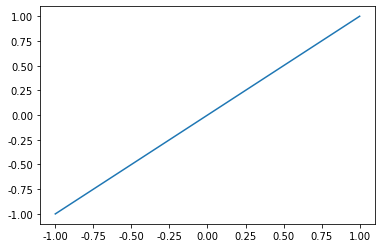

In [234]:

policy_surface=[]
for obs in np.linspace(-1,1,20):
    obs=obs.reshape(1,1)
    action = agent.select_action(torch.from_numpy(obs).float(), action_noise = None, param = None)  
    policy_surface.append(obs[0,0])
plt.plot(np.linspace(-1,1,20),policy_surface)

Text(0.5, 0, 'time')

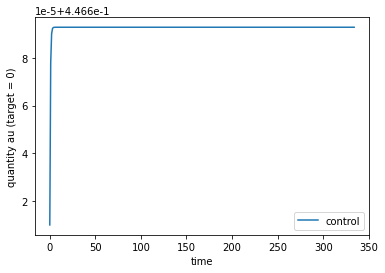

In [237]:
# eval
done=False
obs=env.reset()
while not done:
    action = agent.select_action(torch.from_numpy(obs).float(), action_noise = None, param = None) 
    obs, reward, done = env.step(np.array(action))

%matplotlib inline
plt.plot([x[0,0] for x in env.xs], 'r', label='state (pos)')
plt.plot(np.array(env.us).reshape(-1), label='control')
plt.legend()
plt.ylabel('quantity au (target = 0)')
plt.xlabel('time')